In [1]:
import os
import sys

# 1. Mengeset variabel yang menyimpan lokasi di mana Spark diinstal
spark_path = "D:/spark"

# 2. Menentukan environment variable SPARK_HOME
os.environ['SPARK_HOME'] = spark_path

# 3. Simpan lokasi winutils.exe sebagai environment variable HADOOP_HOME
os.environ['HADOOP_HOME'] = spark_path

# 4. Lokasi Python yang dijalankan --> punya Anaconda
#    Apabila Python yang diinstall hanya Anaconda, maka tidak perlu menjalankan baris ini.
os.environ['PYSPARK_PYTHON'] = sys.executable

# 5. Konfigurasi path library PySpark
sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.10.4-src.zip")

# 6. Import library Spark
#    Dua library yang WAJIB di-import adalah **SparkContext** dan **SparkConf**.
from pyspark import SparkContext
from pyspark import SparkConf

# Setting konfigurasi (opsional)
conf = SparkConf()
conf.set("spark.executor.memory", "2g")
conf.set("spark.cores.max", "4")

sc = SparkContext("local", conf=conf)
#    Apabila berhasil, maka ketika sc di-print akan mengeluarkan nilai <pyspark.context.SparkContext object>
print sc

In [2]:
# Load and parse the data
path = "D:/spark/tugas4/ufo-sightings/scrubbed.csv"
data = sc.textFile(path)
print data

D:/spark/tugas4/ufo-sightings/scrubbed.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0


In [3]:
#numpy array
from numpy import array
from math import sqrt
#regular expression
import re
#kmeans lib
from pyspark.mllib.clustering import KMeans, KMeansModel

In [6]:
#get 20 data teratas
data.take(20)

[u'datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude ',
 u'10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,"This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The Baptist Church sit",4/27/2004,29.8830556,-97.9411111',
 u'10/10/1949 21:00,lackland afb,tx,,light,7200,1-2 hrs,"1949 Lackland AFB&#44 TX.  Lights racing across the sky &amp; making 90 degree turns on a dime.",12/16/2005,29.38421,-98.581082',
 u'10/10/1955 17:00,chester (uk/england),,gb,circle,20,20 seconds,"Green/Orange circular disc over Chester&#44 England",1/21/2008,53.2,-2.916667',
 u'10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,"My older brother and twin sister were leaving the only Edna theater at about 9 PM&#44...we had our bikes and I took a different route home",1/17/2004,28.9783333,-96.6458333',
 u'10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,"AS a Marine 1st Lt. flying an

In [7]:
#get header
header = data.take(1)[0]
print header

datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude 


In [8]:
data = data.filter(lambda row: row!=header)
print data

PythonRDD[6] at RDD at PythonRDD.scala:48


In [10]:
#RDD type data
parsedData = data.map(lambda row: row.split(','))
parsedData = parsedData.map(lambda row: (row[9],row[10]))
parsedData = parsedData.filter(lambda row: re.match('^([0-9])+\.([0-9])*$',row[0]) and re.match('^([0-9])+\.([0-9])*$',row[1]))
parsedData = parsedData.map(lambda row: (float(row[0]),float(row[1])))
print parsedData

PythonRDD[8] at RDD at PythonRDD.scala:48


In [11]:
#Build the model (cluster the data)
clusters = KMeans.train(parsedData, 3, maxIterations=2, initializationMode="random")

In [12]:
#Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 24335.3805717


In [13]:
predict = parsedData.map(clusters.predict)
label = predict.collect()
print label

[0, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 2, 0, 1, 2, 1, 0, 0, 2, 1, 1, 2, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 0, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 2, 1, 1, 0, 2, 0, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 2, 1, 2, 0, 0, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 2, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 2, 1, 1, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 2, 0, 2, 1, 1, 1, 0, 1, 2, 2, 1, 0, 0, 1, 2, 2, 1, 2, 1, 

In [16]:
import matplotlib.pyplot as plt

In [17]:
x_axis = parsedData.map(lambda row: row[0]).collect()
y_axis = parsedData.map(lambda row: row[1]).collect()

In [18]:
#kelas warna label
for i in range(len(label)):
    if (label[i]==1):
        color = "r";
    elif (label[i]==2):
        color = "g";
    else:
        color = "b";
    
    lines = plt.plot(x_axis[i], y_axis[i], 'o')
    plt.setp(lines, color=color, linewidth=2.0)

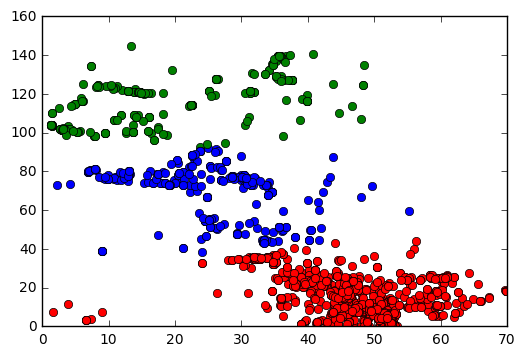

In [19]:
#show grafik
plt.show()